In [105]:
import pandas as pd
import numpy as np
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.preprocessing import StandardScaler
from   sklearn import svm
from   sklearn.svm import SVC
from   sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from joblib import load
import os 

In [216]:
dfs = []

base_path = "C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Dataset-FallWatch"
for i in range(1,6):
    folder_name_avd = f"U{i:02d}\\AVD's"
    folder_name_fall = f"U{i:02d}\\Falls"
    
    folder_path_avd = os.path.join(base_path, folder_name_avd)
    folder_path_fall = os.path.join(base_path, folder_name_fall)
    
    for j in range(1, 12):
        file_name_avd = f'U{i:02d} - D{j:02d}.csv'
        file_path_avd = os.path.join(folder_path_avd, file_name_avd)
        
        file_name_fall = f'U{i:02d} - F{j:02d}.csv'
        file_path_fall = os.path.join(folder_path_fall, file_name_fall)
        
        if os.path.exists(file_path_avd):
            dataframe = pd.read_csv(file_path_avd)
            dataframe['idUsuario'] = f'U{i:02d}'
            dataframe['idTipoMovimento'] = f'D{j:02d}'
            dfs.append(dataframe)
            
        if os.path.exists(file_path_fall):
            dataframe = pd.read_csv(file_path_fall)
            dataframe['idUsuario'] = f'U{i:02d}'
            dataframe['idTipoMovimento'] = f'F{j:02d}'
            dfs.append(dataframe)

dataframe = pd.concat(dfs, ignore_index=True)

movimentos_formatados = {"D01":"Caminhando",
"D02":"Correndo",
"D03":"Subindo e descendo escadas",
"D04":"Sentando em uma cadeira, esperar um momento e levantar-se",
"D05":"Sentado por um momento, tentar levantar-se e cair na cadeira",
"D06":"Agachando (dobrando os joelhos), amarrar sapatos e levantar-se",
"D07":"Tropeçar enquanto caminha",
"D08":"Pular suavemente sem cair(tentando alcançar um objeto)",
"D09":"Bater na mesa com a mão",
"D10":"Batendo palmas",
"F01":"Queda para frente ao caminhar causada por escorregão",
"F02":"Queda lateral ao caminhar causada por escorregão",
"F03":"Queda para trás ao caminhar causada por escorregão",
"F04":"Queda para frente ao caminhar causada por tropeço",
"F05":"Queda para trás ao tentar sentar-se",
"F06":"Queda para frente enquanto sentado, causada por desmaio ou adormecimento",
"F07":"Queda para trás enquanto sentado, causada por desmaio ou adormecimento",
"F08":"Queda lateral enquanto sentado, causada por desmaio ou adormecimento",
}

colunas_selecionadas = ['idUsuario','tempo','acelX', 'acelY', 'acelZ' ,'idTipoMovimento']
dataframe = dataframe[colunas_selecionadas]
dataframe['MAGNITUDE_ACEL']   = np.sqrt(dataframe['acelX']**2 + dataframe['acelY']**2 + dataframe['acelZ']**2)
dataframe = dataframe[dataframe['idTipoMovimento'].isin(['D04'])]
# dataframe = dataframe[dataframe['idUsuario'].isin(['U01','U'])]


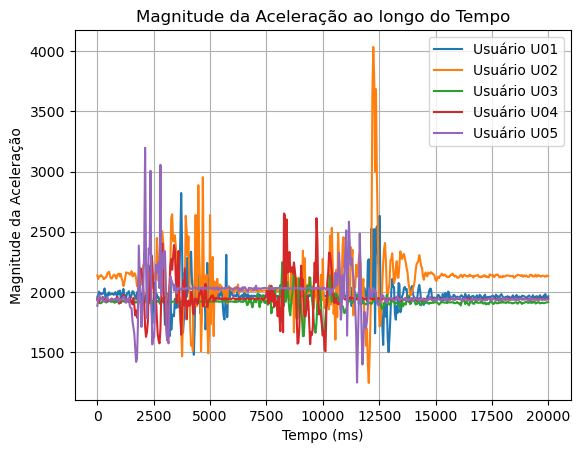

In [217]:
for user_id in dataframe['idUsuario'].unique():
    user_data = dataframe[dataframe['idUsuario'] == user_id]
    plt.plot(user_data['tempo'], user_data['MAGNITUDE_ACEL'], label=f'Usuário {user_id}')

plt.xlabel('Tempo (ms)')
plt.ylabel('Magnitude da Aceleração')
plt.title('Magnitude da Aceleração ao longo do Tempo')
plt.grid(True)
plt.legend()
plt.show()

In [231]:
dataframe = dataframe.reset_index(drop=True)
print(dataframe.index)

def calcula_media_max_min(data,start_time,win_size=50): 
    avg=0
    min_mag=1e9
    max_mag=-1e9
    diff_max_min=0
    for i in range(start_time,start_time+win_size):
        if(i>=len(data)):
            break
        mag=(data.loc[i,'MAGNITUDE_ACEL'])
        avg+=mag
        min_mag=min(min_mag,mag)
        max_mag=max(max_mag,mag)
        diff_max_min=max(diff_max_min,max_mag-min_mag)
    return round(avg/win_size,2),min_mag,max_mag,diff_max_min

for i in range(0,dataframe.index[-1],50):
        if((i>=250 and i<500) or (i>=1050 and i<1500) or (i>=2000 and i<2300) or (i>=2700 and i<=3000)):
                print(f'Janela de 50 amostras que começa no índice ({i}) do dataframe completo',calcula_media_max_min(dataframe,i,50))


RangeIndex(start=0, stop=2505, step=1)
Janela de 50 amostras que começa no índice (250) do dataframe completo (1967.24, 1881.713315040312, 2039.3295466893035, 157.61623164899152)
Janela de 50 amostras que começa no índice (300) do dataframe completo (1996.97, 1498.668075325554, 2632.086814677662, 1133.418739352108)
Janela de 50 amostras que começa no índice (350) do dataframe completo (1958.72, 1891.1134286446172, 2058.01287653892, 166.89944789430274)
Janela de 50 amostras que começa no índice (400) do dataframe completo (1958.49, 1926.4809887460608, 1983.0042864300622, 56.52329768400136)
Janela de 50 amostras que começa no índice (450) do dataframe completo (1957.05, 1936.9062961330885, 1980.2863429312438, 43.38004679815526)
Janela de 50 amostras que começa no índice (1050) do dataframe completo (1918.17, 1904.0391277492172, 1924.7781690366296, 20.73904128741242)
Janela de 50 amostras que começa no índice (1100) do dataframe completo (1918.97, 1913.7006035427798, 1923.294569222302, 9.

c:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\julia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


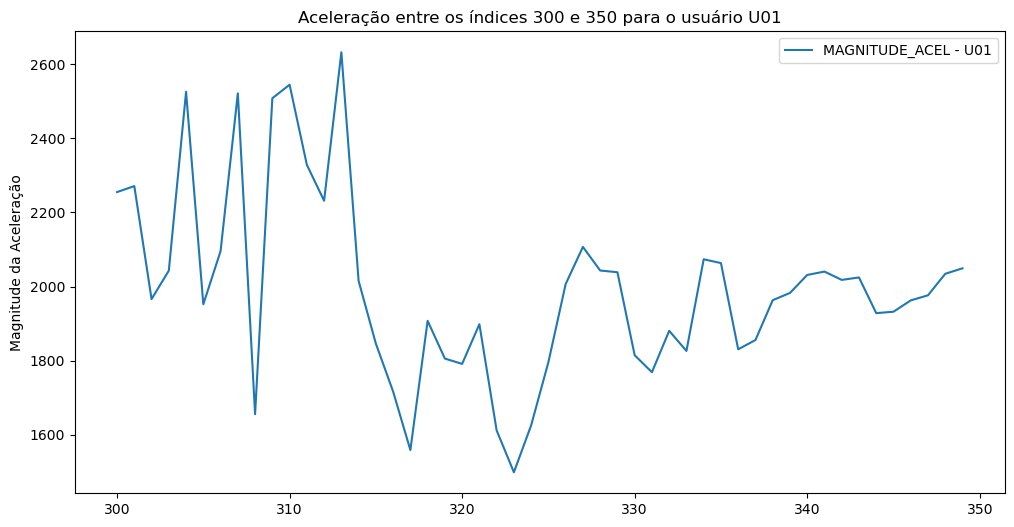

Intervalo (300, 350) fora dos limites para o usuário U02.
Intervalo (300, 350) fora dos limites para o usuário U03.
Intervalo (300, 350) fora dos limites para o usuário U04.
Intervalo (300, 350) fora dos limites para o usuário U05.


In [227]:
def plot(df, start, end, showx=False, showy=False, showz=False, showTotal=True, users=None):
    if users is None:
        users = df['idUsuario'].unique()

    for user in users:
        user_df = df[df['idUsuario'] == user]
        
        if start < user_df.index.min() or end > user_df.index.max():
            print(f"Intervalo ({start}, {end}) fora dos limites para o usuário {user}.")
            continue

        user_data = user_df[start:end]

        legend_lst = []
        plot_params = {
            'acelX': showx,
            'acelY': showy,
            'acelZ': showz,
            'MAGNITUDE_ACEL': showTotal
        }
        
        plt.figure(figsize=(12, 6))  

        for col, show in plot_params.items():
            if show:
                sns.lineplot(y=user_data[col], x=user_data.index, label=f'{col} - {user}')
                legend_lst.append(f'{col} - {user}')
        
        plt.legend(legend_lst)
        plt.ylabel("Magnitude da Aceleração")
        plt.title(f"Aceleração entre os índices {start} e {end} para o usuário {user}", fontsize=12)
        plt.show()

plot(dataframe, 300, 350)  


In [232]:
# 0 - É D04
# 1 - Não é D04

def extrai_features(data, start_time, win_size=50):
    avg, min_mag, max_mag, diff_max_min = calcula_media_max_min(data, start_time, win_size)
    return [start_time, avg, min_mag, max_mag, diff_max_min]

features = []

for i in range(0, dataframe.index[-1], 50):
    if (i >= 250 and i < 500) or (i >= 1050 and i < 1500) or (i >= 2000 and i < 2300) or (i >= 2700 and i <= 3000):
        features.append(extrai_features(dataframe, i, 50))
dataframe_com_features = pd.DataFrame(features, columns=['Início_janela', 'Média', 'Mínimo', 'Máximo', 'Diferença Máx-Min'])
# print(features_df.head())

def identifica_outliers_com_iqr(df, feature_name):
    Q1 = df[feature_name].quantile(0.25)
    Q3 = df[feature_name].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return limite_inferior, limite_superior

dataframe_com_features['Label'] = 0

for feature in ['Média', 'Mínimo', 'Máximo', 'Diferença Máx-Min']:
    limite_inferior, limite_superior = identifica_outliers_com_iqr(dataframe_com_features, feature)

    confirma_outlier = (dataframe_com_features[feature] < limite_inferior) | (dataframe_com_features[feature] > limite_superior)
    dataframe_com_features.loc[confirma_outlier, 'Label'] = 1
    
print(dataframe_com_features)


    Início_janela    Média       Mínimo       Máximo  Diferença Máx-Min  Label
0             250  1967.24  1881.713315  2039.329547         157.616232      0
1             300  1996.97  1498.668075  2632.086815        1133.418739      1
2             350  1958.72  1891.113429  2058.012877         166.899448      0
3             400  1958.49  1926.480989  1983.004286          56.523298      0
4             450  1957.05  1936.906296  1980.286343          43.380047      0
5            1050  1918.17  1904.039128  1924.778169          20.739041      0
6            1100  1918.97  1913.700604  1923.294569           9.593966      0
7            1150  1922.78  1820.776208  2041.694639         220.918431      0
8            1200  1930.25  1630.798884  2245.978183         615.179299      1
9            1250  1903.69  1635.676618  2136.440264         500.763645      0
10           1300  1911.14  1856.155974  1976.440487         120.284513      0
11           1350  1910.07  1887.838446  1938.903298

In [230]:
X = dataframe_com_features[['Média', 'Mínimo', 'Máximo', 'Diferença Máx-Min']]
y = dataframe_com_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='linear', random_state=42) 
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

Matriz de Confusão:
 [[3 0]
 [1 2]]
